<a href="https://colab.research.google.com/github/swjh9523/Perfect_Guide_Python/blob/main/07_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%ED%83%80%EC%9D%B4%ED%83%80%EB%8B%89_%EC%83%9D%EC%A1%B4%EC%9E%90_ML%EC%98%88%EC%B8%A1_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 타이타닉 생존자 ML 예측 구현

 * 1. 데이터 전처리
    * Null 처리
    * 불필요한 속성 제거
    * 인코딩 수행

* 2. 모델 학습 및 검증/예측/평가
    * 결정트리, 랜덤포레스트, 로지스틱 회귀 학습 비교
    * K 폴드 교차 검증
    * cross_val_score()와 GridSearchCV()수행
    


In [88]:
# 라이브러리 임포트 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from google.colab import files

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


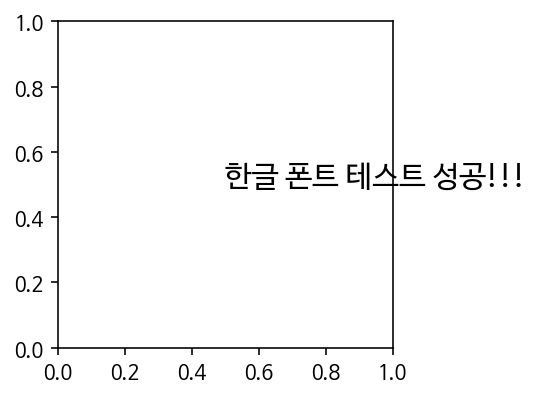

In [89]:
# 그래프 한글폰트 사용설정 in Colab

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum

fontpath = '/content/drive/My Drive/파이썬/NanumGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

## Test
plt.figure(figsize=(3,3))
plt.text(0.5, 0.5, '한글 폰트 테스트 성공!!!', size=15)
plt.show()

In [90]:
# 데이터 불러오기

data = pd.read_csv('/content/train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


* PassengerId : 탑승자 데이터 일련번호
* Survived : 생존여부 0 = 사망, 1 = 생존
* Pclass : 티켓의 선실 등급 1 = 일등석, 2 = 이등석 3 = 삼등석 
* Name : 탑승자 이름
* Sex : 탑승자 성별
* Age : 탑승자 나이
* SibSp : 같이 탑승한 형제자매 또는 배우자 인원 수
* Parch : 같이 탑승한 부모님 또는 어린이 인원 수
* Ticket : 티켓 번호
* Fare : 요금
* Cabin : 선실 번호
* Embarked : 중간 정착 항구 C = Cherbourg, Q = Queenstown, S = Southampton

## 데이터 전처리


* null값 처리

In [91]:
# 데이터 정보 파악하기

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


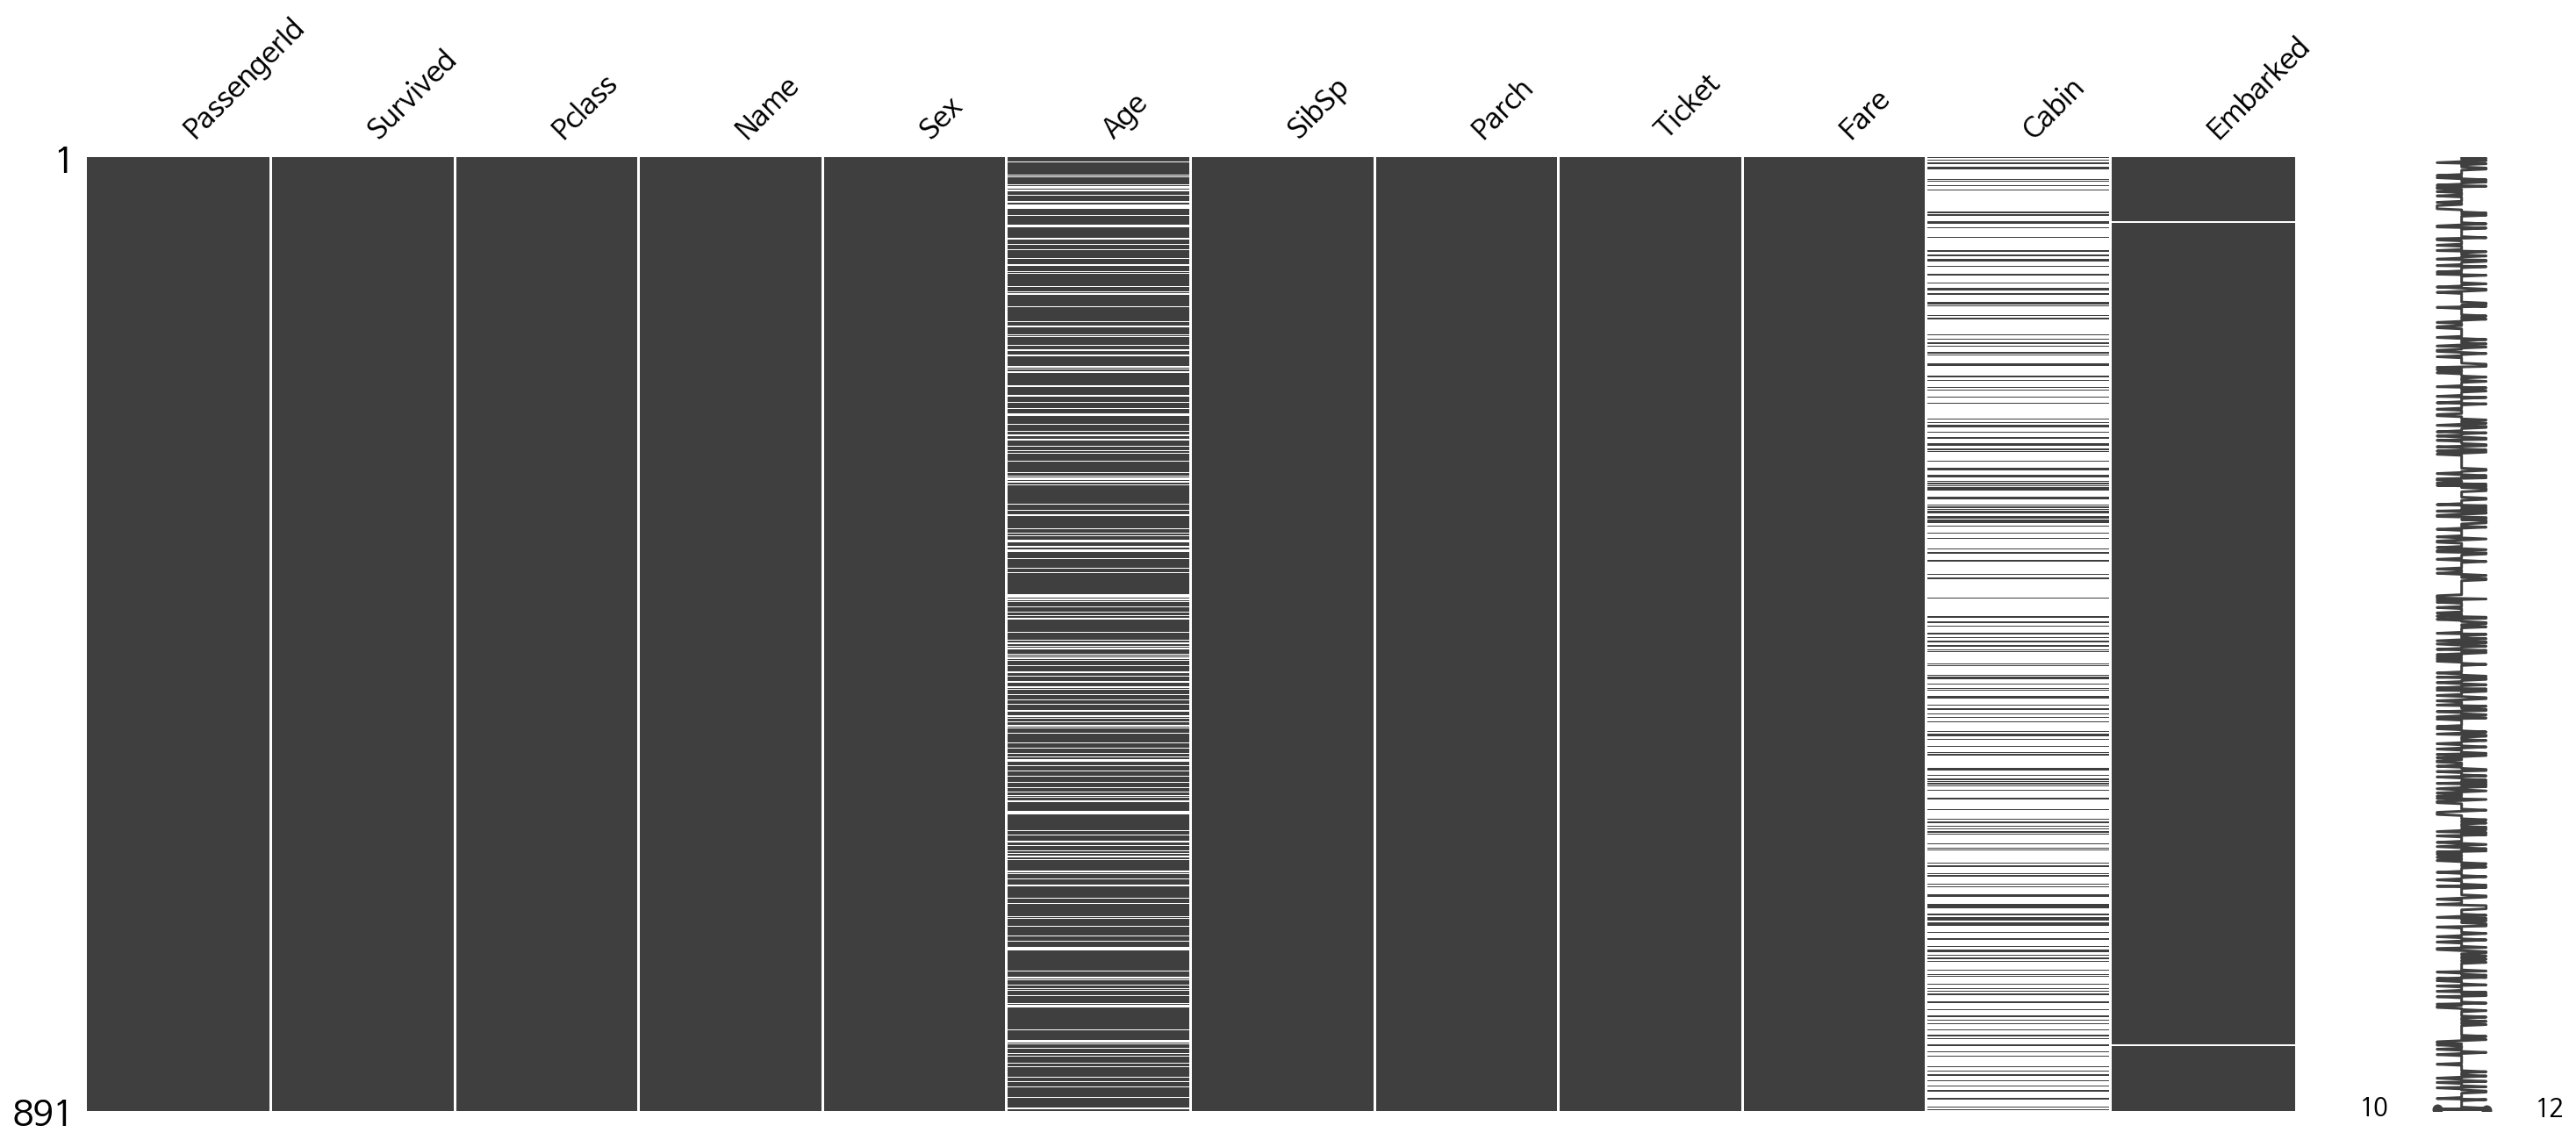

In [92]:
# 결측값 확인

import missingno
missingno.matrix(data)

In [93]:
# 결측치 처리하기

null = data.isnull().sum()
print(null)

# 개별값 확인

print(data['Age'].unique())
print(data['Cabin'].unique())
print(data['Embarked'].unique())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
[22.   38.   26.   35.     nan 54.    2.   27.   14.    4.   58.   20.
 39.   55.   31.   34.   15.   28.    8.   19.   40.   66.   42.   21.
 18.    3.    7.   49.   29.   65.   28.5   5.   11.   45.   17.   32.
 16.   25.    0.83 30.   33.   23.   24.   46.   59.   71.   37.   47.
 14.5  70.5  32.5  12.    9.   36.5  51.   55.5  40.5  44.    1.   61.
 56.   50.   36.   45.5  20.5  62.   41.   52.   63.   23.5   0.92 43.
 60.   10.   64.   13.   48.    0.75 53.   57.   80.   70.   24.5   6.
  0.67 30.5   0.42 34.5  74.  ]
[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' '

In [94]:
# 결측 컬럼 처리하기

data["Age"].fillna(data['Age'].mean(),inplace=True)
data['Cabin'].fillna('N', inplace=True)
data['Embarked'].fillna('N', inplace=True)

print(data.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [96]:
# object 변수의 분포 확인
print(data['Sex'].value_counts())
print('\n', data['Cabin'].value_counts())
print('\n',data['Embarked'].value_counts())

male      577
female    314
Name: Sex, dtype: int64

 N              687
C23 C25 C27      4
B96 B98          4
G6               4
D                3
              ... 
F E69            1
C46              1
B69              1
A7               1
B50              1
Name: Cabin, Length: 148, dtype: int64

 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


In [98]:
# Cabin 변수에서 앞글자만 가져오기
data['Cabin'] = data['Cabin'].str[:1]

# 전처리 된 최종 데이터를 df로 저장하기

df = data.copy()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,N,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,N,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,N,S


In [99]:
# 성별에 따른 생존자 수 파악
df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

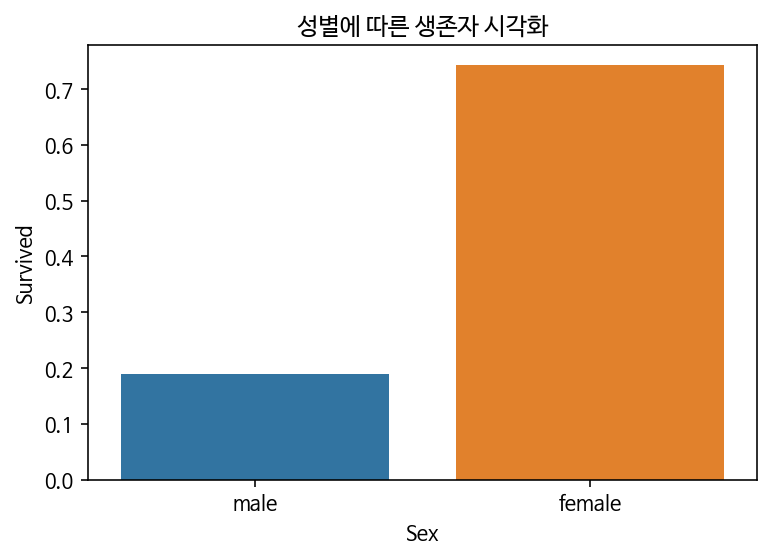

In [100]:
# 성별에 따른 생존자수 시각화
plt.title('성별에 따른 생존자 시각화')
sns.barplot(data=df, x='Sex', y='Survived',ci=None)

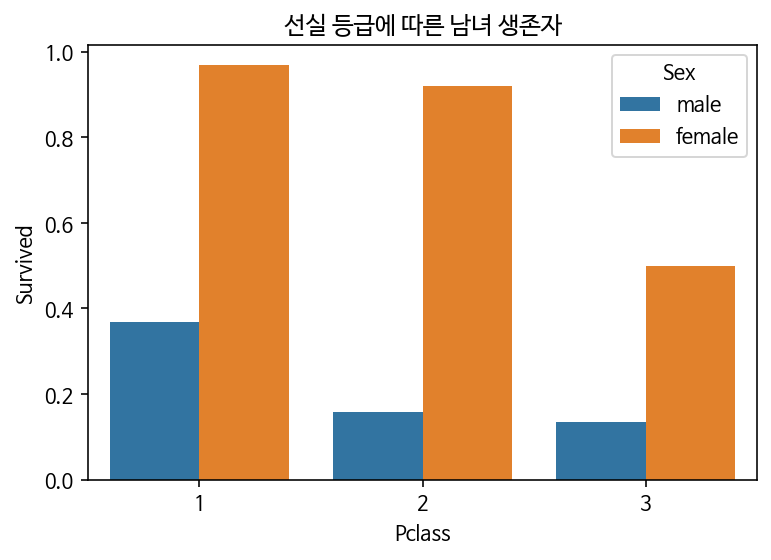

In [101]:
# 선실 등급에 따른 남녀 생존자수 파악
plt.title('선실 등급에 따른 남녀 생존자')
sns.barplot(data=df, x='Pclass', y='Survived', hue="Sex",ci=None)

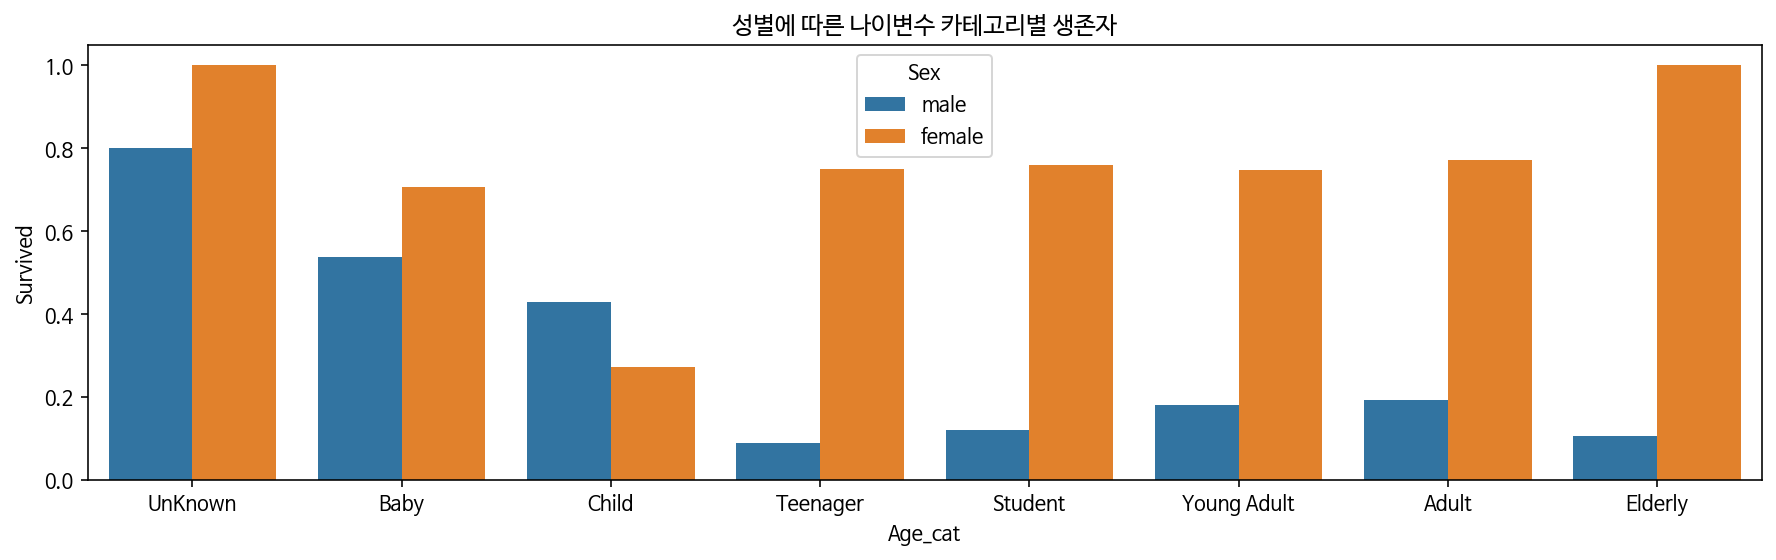

In [127]:
def get_category(age):
  cat = ''
  if age <= 1: cat = 'UnKnown'
  elif age <= 5: cat = 'Baby'
  elif age <= 12: cat = 'Child'
  elif age <= 18: cat = 'Teenager'
  elif age <= 25: cat = 'Student'
  elif age <= 35: cat = 'Young Adult'
  elif age <= 60: cat = 'Adult'
  else : cat = 'Elderly'

  return cat


df["Age_cat"] = df['Age'].apply(lambda x: get_category(x))
order = ['UnKnown','Baby','Child','Teenager','Student','Young Adult','Adult','Elderly']

plt.figure(figsize=(15,4))
plt.title('성별에 따른 나이변수 카테고리별 생존자')
sns.barplot(data=df, x='Age_cat', y='Survived',hue='Sex', ci=None, order=order)
df = df.drop(['Age_cat'], axis=1)

In [157]:
from sklearn.preprocessing import LabelEncoder

# 문자형 변수 인코딩 ['Sex', 'Cabin', 'Embarked']
le = LabelEncoder()
Sex_feature = df['Sex'].to_list()

le.fit(Sex_feature)
df['le_Sex'] = le.transform(Sex_feature)

Cabin_feature = df['Cabin'].to_list()
le.fit(Cabin_feature)
df['le_Cabin'] = le.transform(Cabin_feature)

Embarked_feature = df['Embarked'].to_list()
le.fit(Embarked_feature)
df['le_Embarked'] = le.transform(Embarked_feature)

# 필요없는 컬럼 제거
df = df.drop(['Sex','Cabin','Embarked'],axis=1).copy()
df.drop(['PassengerId','Name','Ticket'],axis = 1, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,le_Sex,le_Cabin,le_Embarked
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,1,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,0,2,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,0,2,3
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,1,7,3


In [171]:
from sklearn.model_selection import train_test_split

target_df = df['Survived'].copy()
feature_df = df.drop(['Survived'],axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(feature_df, target_df,
                                                    test_size=0.2, random_state = 11)

In [187]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier 학습 / 예측 / 평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 예측 정확도 : ',round(accuracy_score(y_test, dt_pred),2))

# RandomForestClassifier 학습 / 예측 / 평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 예측 정확도 : ',round(accuracy_score(y_test, rf_pred),2))

# LogisticRegreesion 학습/예측/평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegreesion 예측 정확도 : ',round(accuracy_score(y_test, lr_pred),2))

DecisionTreeClassifier 예측 정확도 :  0.79
RandomForestClassifier 예측 정확도 :  0.85
LogisticRegreesion 예측 정확도 :  0.85


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [201]:
# KFold 교차검증 KFold 교차검증

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, feature_df, target_df, scoring='accuracy', cv=5)
print(np.round(scores,2))
print('평균 정확도 : ', round(scores.mean(),2))

[0.74 0.77 0.79 0.79 0.82]
평균 정확도 :  0.78


In [ ]:
from sklearn.model_selection import GridSearchCV
